In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# hyperparams
num_classes = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])


dataset_train = datasets.CIFAR10('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.CIFAR10('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
dataset_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

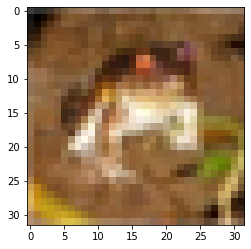

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(dataset_train.data[0])
plt.show()

In [ ]:
class ResBlock(nn.Module):

    def __init__(self, input_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_planes, planes, stride=stride, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, stride=1, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(planes)
        self.activ= nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self,x):

        origin_x = x

        output = self.conv1(x)
        output = self.bn1(output)
        output = self.activ(output)
        output = self.conv2(output)
        output = self.bn2(output)

        if self.downsample is not None:
            origin_x = self.downsample(origin_x)
        
        output += origin_x
        output = self.activ(output)

        return output


class ResNet(nn.Module):
    def __init__(self, block, num_layers, classes=10):
        super().__init__()

        self.input_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.activ= nn.ReLU(inplace=True) 

        self.layer1 = self._layer(block, 64, num_layers[0], stride=1)
        self.layer2 = self._layer(block, 128, num_layers[1], stride=2)
        self.layer3 = self._layer(block, 256, num_layers[2], stride=2)
        self.layer4 = self._layer(block, 512, num_layers[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4, stride=1)
        self.fc = nn.Linear(512, classes)
    
    def _layer(self, block, planes, num_layers, stride=1):
        downsample = None
        if stride!=1 or planes != self.input_planes:
            downsample = nn.Sequential(nn.Conv2d(self.input_planes,planes,kernel_size=1,stride=stride),
                                       nn.BatchNorm2d(planes))
        netLayers =[]
        netLayers.append(block(self.input_planes, planes, stride=stride, downsample=downsample))
        self.input_planes = planes
        for i in range(1, num_layers):
            netLayers.append(block(self.input_planes,planes))
        
        return nn.Sequential(*netLayers)

    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activ(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x

In [ ]:
ResNet18 = ResNet(ResBlock, num_layers=[2,2,2,2], classes=10)

ResNet18.to(device)
optim = torch.optim.Adam(ResNet18.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
losses = []
losses_test = []
accuracy = 0
max_accuracy = 0
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = ResNet18(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        losses.append(loss.item())
        # print(losses)
        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    #test model
    for i, batch in enumerate(testloader):
        inputs, labels = batch

        ResNet18.eval()
        loss_test = 0
        with torch.no_grad():
            predict = ResNet18(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
            losses_test.append(loss_test.item())
            
            accuracy = accuracy_score(labels.to(device), predict)
            if accuracy > max_accuracy:
              torch.save(ResNet18.state_dict(), f'./best_by_accuracy.pth')


    ResNet18.train()
    print('test loss:', loss_test / i)

    #save every epoch
    torch.save(ResNet18.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.357732057571411
epoch: 0, step: 100, loss: 1.382451057434082
epoch: 0, step: 200, loss: 1.246788501739502
epoch: 0, step: 300, loss: 1.1876980066299438


ValueError: ignored